# Lab04: Genetic Algorithms 

Overview of the lab: 
1. Introduction to Genetic Algorithms
2. Main steps in Genetic Algorithms 
    * Selection
    * Crossover
    * Mutation
3. Traveling Salesman Problem
4. Knapsack Problem
5. Types of crossover
----

## 1. Introductionn to Genetic algorithms

* A ***search and optimization technique*** inspired by natural evolution.
* Uses the principles of selection, crossover, and mutation.
* Evolves a population of possible solutions to find the best (fittest) one.

Each solution (often called an individual or chromosome) is represented by a set of parameters — similar to genes in biology. The fitness of each individual measures how well it solves the problem at hand.

Key Concepts:

* ***Gene*** → A single parameter or feature that defines part of a solution.
(Example: weight, value, or decision variable)

* ***Chromosome*** → A complete set of genes; represents one potential solution.
(Example: [x₁, x₂, x₃, …])

* ***Population*** → A group of chromosomes; represents many solutions being tested at once.

## 2.  Main steps in Genetic Algorithms 
Initialization (Population) $\rightarrow$ Selection (Fitness Function) $\rightarrow$ Crossover $\rightarrow$ Mutation

![ga_scheme](images/ga_scheme.jpg)

## 2.1. Selection
Selection is the stage of a genetic algorithm in which individual chromosomes are chosen from a population for later breeding (using the crossover operator).

In genetic algorithms (GAs), ***selection pressure*** refers to how strongly the algorithm favors the best-performing individuals (solutions) when choosing who gets to reproduce and create the next generation.

*Selection pressure* is the degree of bias towards fitter individuals in the selection process.
* ***High selection pressure*** → strongly favors the best individuals
   * → faster convergence, but risk of premature convergence (loss of diversity, stuck in local optima).
* ***Low selection pressure*** → individuals are chosen more randomly
   * → slower convergence, but better exploration of the search space (more genetic diversity).

### Roulette Wheel🎯

Chromosomes are selected with a probability proportional to their fitness. Compute each individual’s selection **probability = (individual fitness / total fitness)**

Imagine a roulette wheel where each chromosome has a slot size corresponding to its fitness value; fitter individuals have larger slots and are more likely to be selected.

|             Pros                 | Cons                                                                                         |
|  ------------------------------- | ------------------------                                                                     | 
|  Simple                          | Premature convergence if a single individual is overwhelmingly fit (takes over the wheel).   |
| Works well when fitness differences are moderate. | Sensitive to scaling: small differences in fitness can have a large effect. |

1. Calculate the total fitness of the population.
2. Compute each individual’s selection probability = (individual fitness / total fitness).
3. Spin the wheel (generate a random number) to select individuals based on these probabilities.

In [39]:
import numpy as np

population = ['A', 'B', 'C', 'D', 'E']
fitness_scores = [10, 20, 30, 25, 15] #higher is better

In [43]:
def roulette_wheel_selection(population, fitness_scores, num_selections):
   total_fitness = sum(fitness_scores)
   selection_probs = [f / total_fitness for f in fitness_scores]
   selected_chromosomes = np.random.choice(population, size=num_selections, replace=True, p=selection_probs)
   return selected_chromosomes

selected = roulette_wheel_selection(population, fitness_scores, 3)
print("Selected chromosomes:", selected)

Selected chromosomes: ['A' 'C' 'C']


`np.random.choice` is used to randomly select elements from an array (or a range of integers).
It can sample with or without replacement and can also use probabilities for weighted selection. 

More in [NumPy_notes](/00_NumPy_notes.ipynb)

the argument `replace=True` controls whether the same element can be chosen more than once.

* `replace=True` → sampling with replacement

   * The same chromosome (individual from the population) can be selected multiple times.
   * After one is chosen, it’s still "available" for future selections.
   * This is common in genetic algorithms, because the most fit individuals can be selected more than once (proportional to their selection probability).

* `replace=False` → sampling without replacement
  * Once an element is chosen, it cannot be selected again.
  * This ensures all selected chromosomes are unique.

### Tournament Selection 🏆
Randomly select a small group (a “tournament”) of individuals and pick the best one from that group to be a parent.
  * Selection pressure can be controlled by changing 𝑘.
      * Larger $k$ → stronger selection pressure (more elitist).
      * Smaller 𝑘: → more diversity.

|             Pros                 | Cons                                                                                         |
|  ------------------------------- | ------------------------                                                                     | 
|  Easy to implement. Selection pressure can be controlled by changing 𝑘.  | May lose diversity if tournament size is too large.  |

In [28]:
#Implementation of Tournament Selection with indexes
def tournament_selection(population, fitness_scores, tournament_size, num_selections):
   selected_chromosomes = []
   for _ in range(num_selections):
        #choose random indexes of chromosomes from the population for the tournament
        tournament = np.random.choice(len(population), tournament_size, replace=False)

        #chromosomes in the tournament
        selected_population = [population[i] for i in tournament]
        print("Tournament participants:", selected_population)
        print("Fitness scores:", [fitness_scores[i] for i in tournament])

        #select the index of best chromosome from the tournament
        winner = tournament[np.argmax([fitness_scores[i] for i in tournament])]
        print("Tournament winner:", population[winner])
        selected_chromosomes.append(population[winner])

   return selected_chromosomes

selected = tournament_selection(population, fitness_scores, tournament_size=3, num_selections=3)
print("Selected:", selected)

Tournament participants: ['A', 'E', 'B']
Fitness scores: [10, 15, 20]
Tournament winner: B
Tournament participants: ['B', 'A', 'D']
Fitness scores: [20, 10, 25]
Tournament winner: D
Tournament participants: ['B', 'A', 'D']
Fitness scores: [20, 10, 25]
Tournament winner: D
Selected: ['B', 'D', 'D']


----

### Rank-Based Selection

Instead of using raw fitness values, individuals are ranked according to rank. The selection probability depends on rank, not the absolute fitness.

|             Pros                 | Cons                                                                                         |
|  ------------------------------- | ------------------------                                                                     | 
|  Prevents domination by one very fit individual  | Can be slower to converge because it reduces differences between individuals |
| Maintains steady selection pressure  |                                                                                          |

1. Sort the population by fitness (best to worst).
2. Assign selection probabilities based on rank (e.g., linearly or exponentially decreasing).
3. Select individuals using these rank-based probabilities.

In [35]:
def rank_based_selection(population, fitness_scores, num_selections):
   # Rank individuals based on fitness
    sorted_indices = np.argsort(fitness_scores)
    sorted_fitness = [(i, fitness_scores[i], population[i]) for i in sorted_indices]
    print("Sorted indices and their scores:", sorted_fitness)

    ranks = np.arange(1, len(fitness_scores)+1)
    print("Ranks:", ranks)

    probs = ranks / np.sum(ranks)
    print("Selection probabilities:", probs)
    print("Elements by rank: ", np.array(population)[sorted_indices])

    chosen = np.random.choice(np.array(population)[sorted_indices], size=num_selections, p=probs)
    return chosen

selected = rank_based_selection(population, fitness_scores, num_selections=3)
print("Selected chromosomes:", selected)

Sorted indices and their scores: [(0, 10, 'A'), (4, 15, 'E'), (1, 20, 'B'), (3, 25, 'D'), (2, 30, 'C')]
Ranks: [1 2 3 4 5]
Selection probabilities: [0.06666667 0.13333333 0.2        0.26666667 0.33333333]
Elements by rank:  ['A' 'E' 'B' 'D' 'C']
Selected chromosomes: ['B' 'D' 'E']


`numpy.arange([start,] stop[, step,] dtype=None)`

It creates an array with evenly spaced values within a given range — similar to Python’s built-in range(), but returns a NumPy array instead of a list.
 * ***Python list:*** Can store mixed data types in the same list.
 * ***NumPy array:*** All elements must have the same data type. NumPy will try to cast them to a common type.

 More information in [NumPy_notes](/00_NumPy_notes.ipynb)

-----

### Stochastic Universal Sampling (SUS) 🎲

A variation of roulette wheel selection that ensures a more even and consistent spread of selected individuals.

Imagine the roulette wheel as before, but instead of one spin, place multiple evenly spaced pointers on it (equal to the number of parents needed).
   * Spin the wheel once — all pointers select individuals simultaneously.
   
|             Pros                 | Cons                                                                                         |
|  ------------------------------- | ------------------------                                                                     | 
| Reduces randomness in selection (less variance)  | Slightly more complex to implement than standard roulette selection.         |
| Ensures even sampling proportional to fitness.  |                                                                               |


### Elitism
The ***best individuals from the current generation*** are automatically passed to the next generation, without alteration.
  
|             Pros                 | Cons                                                                                         |
|  ------------------------------- | ------------------------                                                                     | 
| Guarantees that the best solutions are preserved.  | Reduces diversity         |
| Improves convergence speed.  |                                                                               |


### Truncation Selection
Select only the top fraction of the population (e.g., top 30%) based on fitness. All selected individuals have equal probability of being parents.
  1. Sort population by fitness.
  2. Keep only the top percentage (say, best 20–50%).
  3. Randomly select parents from this truncated set.

|             Pros                 | Cons                                                                                         |
|  ------------------------------- | ------------------------                                                                     | 
| Very simple and deterministic.  | Can quickly reduce genetic diversity.      |
| Strong selection pressure (fast convergence).  |   May get stuck in local optima.


### Summary of Selection Methods

| Method             | Key Idea                        | Strength                 | Weakness               |
| ------------------ | ------------------------------- | ------------------------ | ---------------------- |
| **Roulette Wheel** | Prob. proportional to fitness   | Simple                   | Premature convergence  |
| **Tournament**     | Best of random subset wins      | Adjustable pressure      | Can lose diversity     |
| **Rank-Based**     | Selection by rank               | Stable pressure          | Slower convergence     |
| **SUS**            | Evenly spaced roulette sampling | Low variance             | More complex           |
| **Elitism**        | Best always survive             | Guarantees progress      | Less diversity         |
| **Truncation**     | Top % survive                   | Simple & strong pressure | Fast loss of diversity |

## 2.2 Crossover

Crossover is a process of taking more than one parent solutions and producing a child solution from them.
![crossover](images/crossover.jpg)

There are a lot of types of crossover, such as:
|   Binary coded           | Real Coded               |    Order Coded           |
| ------------------------ | ------------------------ | ------------------------ |
| Single Point             | Linear                   |    Partially-Mapped      |
| Two-Point                | Single Arithmetic        |      Cycle               |
| Multi-Point              |                          |                          |
| Uniform                  |                          |                          |
| Shuffle                  |                          |                          |

### One-point crossover

*parent 1:* **1 2 3** | 4 5 

*parent 2:* **5 4 3** | 2 1

*child1*: 1 2 3 | 5 4 -> copy first part from parent 1 + fill the remaining values in their order from parent 2

*child2:* 5 4 3 | 1 2 -> copy first part from parent 2 + fill the remaining values in their order from parent 1

## 2.3 Mutation

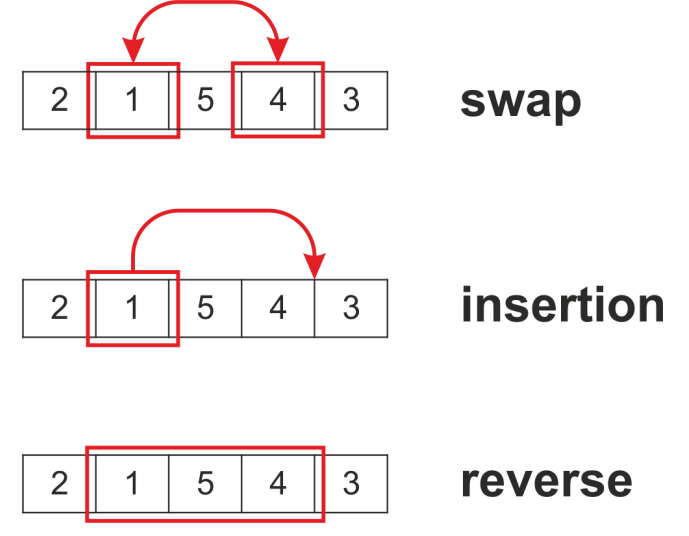

### Uniform Crossover
Getting a gene from one of the parents randomly!

*parent 1:* 1 2 3 4 5 6 7 8 9 1

*parent 2:* 2 3 4 5 5 7 7 9 9 0